# SIMIND Introduction

In [1]:
from __future__ import annotations
import os
from pytomography.io.SPECT import simind
from pytomography.projectors.SPECT import SPECTSystemMatrix
from pytomography.transforms.SPECT import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEM, OSMAPOSL, BSREM, KEM
import matplotlib.pyplot as plt
import torch
from pytomography.priors import RelativeDifferencePrior
from pytomography.priors import TopNAnatomyNeighbourWeight
from pytomography.likelihoods import PoissonLogLikelihood
from pytomography.transforms.shared import KEMTransform
from pytomography.projectors.shared import KEMSystemMatrix


          -  -  -  -  -  -  -  -   -  -  -  -
          P  A  R  A  L  L  E  L | P  R  O  J
          -  -  -  -  -  -  -  -   -  -  -  -


         Please consider citing our publication
      ---------------------------------------------
      Georg Schramm and Kris Thielemans:
      "PARALLELPROJ—an open-source framework for
       fast calculation of projections in
       tomography"
      Front. Nucl. Med., 08 January 2024
      Sec. PET and SPECT, Vol 3
      https://doi.org/10.3389/fnume.2023.1324562

 
    parallelproj C    lib: /data/anaconda/envs/pytomo_install_test/lib/libparallelproj_c.so.1.8.0
    parallelproj CUDA lib: /data/anaconda/envs/pytomo_install_test/lib/libparallelproj_cuda.so.1.8.0
    


Set the folder location for downloaded files (you will need to modify this to be the directory where you saved the files)

In [2]:
path = '/disk1/pytomography_tutorial_data/simind_tutorial/'

## 1. Opening Projection Data

SIMIND simulation data consists of header files `filename.h00` consisting of metadata and associated data files `filename.a00` corresponding to the associated data. To open a single SIMIND simulation file, we use the `simind.get_projections` function

In [3]:
photopeak_path = os.path.join(path, 'multi_projections', 'liver', 'photopeak.h00')
photopeak = simind.get_projections(photopeak_path)

torch.Size([120, 128, 384])


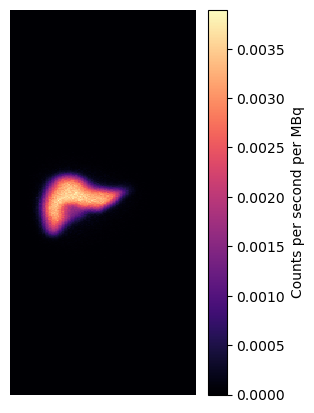

In [4]:
print(photopeak.shape)
plt.figure(figsize=(3,5))
plt.pcolormesh(photopeak[0].cpu().T,  cmap='magma')
plt.axis('off')
plt.colorbar(label = 'Counts per second per MBq')
plt.show()

The projection file has shape (120,128,384) implying there is 1 energy window, and 120 2D projections of shape 128 $\times$ 384.

To open multiple energy windows at once, we feed them in as a list:

In [5]:
photopeak_path = os.path.join(path, 'multi_projections', 'liver', 'photopeak.h00')
upperscatter_path = os.path.join(path, 'multi_projections', 'liver', 'lowerscatter.h00')
lowerscatter_path = os.path.join(path, 'multi_projections', 'liver', 'upperscatter.h00')

In [6]:
projections = simind.get_projections([photopeak_path, upperscatter_path, lowerscatter_path])
projections.shape

torch.Size([3, 120, 128, 384])

Now each element of the first axis corresponds to each energy window specified from the photopeak and upper/lower scatter windows.

Sometimes it is the case that multiple regions are simulated seperately in SIMIND and added together in projection space after the fact. To load in projections this way, we need to specify the relative scaling for each seperate region when adding them together

In [7]:
organs = ['bkg', 'liver', 'l_lung', 'r_lung', 'l_kidney', 'r_kidney','salivary', 'bladder']
activities = [2500, 450, 7, 7, 100, 100, 20, 90] # MBq
headerfiles = [os.path.join(path, 'multi_projections', organ, 'photopeak.h00') for organ in organs]

To load all these projections together and combine them, we include the list of headerfiles as a list within a list (to differentiate them between being different scatter windows)

In [8]:
projections = simind.get_projections([headerfiles], weights=activities)
projections.shape

torch.Size([120, 128, 384])

We can get all three energy windows analogous to the first case:

In [9]:
headerfiles_lower = [os.path.join(path, 'multi_projections', organ, 'lowerscatter.h00') for organ in organs]
headerfiles_upper = [os.path.join(path, 'multi_projections', organ, 'upperscatter.h00') for organ in organs]

In [10]:
projections = simind.get_projections([headerfiles, headerfiles_lower, headerfiles_upper], weights=activities)
projections.shape

torch.Size([3, 120, 128, 384])

Let's plot the first index (photopeak). Because we scaled by activities (units of MBq) in weights, our projections now only have units of counts per second

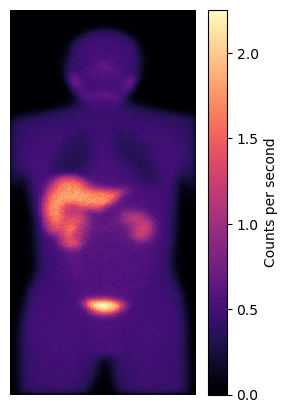

In [11]:
plt.figure(figsize=(3,5))
plt.pcolormesh(projections[0,0].cpu().T,  cmap='magma')
plt.axis('off')
plt.colorbar(label = 'Counts per second')
plt.show()

If we want to simulate a realistic SPECT scan, we need to multiply by the time acquired per projection and add Poisson noise

In [12]:
dT = 15 # seconds per projection
projections_realization = torch.poisson(projections * dT)
photopeak = projections_realization[0]

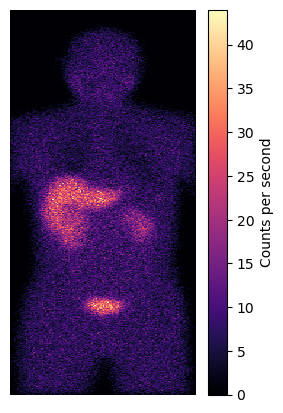

In [13]:
plt.figure(figsize=(3,5))
plt.pcolormesh(photopeak[0].cpu().T,  cmap='magma')
plt.axis('off')
plt.colorbar(label = 'Counts per second')
plt.show()

The scatter can be estimated using the triple energy window technique:

$$s = \left(\frac{p_{upper}}{w_{upper}} + \frac{p_{lower}}{w_{lower}}\right) \frac{w_{peak}}{2}$$


In [14]:
ww_peak = simind.get_energy_window_width(headerfiles[0])
ww_lower = simind.get_energy_window_width(headerfiles_lower[0])
ww_upper = simind.get_energy_window_width(headerfiles_upper[0])
lower_scatter = projections_realization[1]
upper_scatter = projections_realization[2]
scatter = (lower_scatter/ww_lower+upper_scatter/ww_upper)*ww_peak/2

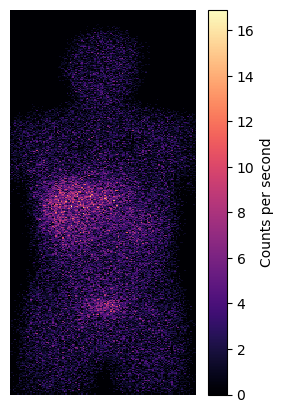

In [15]:
plt.figure(figsize=(3,5))
plt.pcolormesh(scatter[0].cpu().T,  cmap='magma')
plt.axis('off')
plt.colorbar(label = 'Counts per second')
plt.show()

Finally, the required metadata for reconstruction (such as pixel/voxel size, projection angles/radii, etc.) can be obtained from one of the headerfiles

In [16]:
object_meta, proj_meta = simind.get_metadata(headerfiles[0])

## 2. Creating The System Matrix

Once the data and metadata have been loaded, its time to create the system matrix $H$ the models the SPECT system; this system matrix is required for image reconstruction. This requires building up a sequence of **transforms** that each model seperate phenomena in the imaging modality.

The following transform is used for attenuation modeling in the system matrix. It uses a 3D attenuation map generated via SIMIND.

In [17]:
attenuation_path = os.path.join(path, 'multi_projections', 'mu208.hct')
attenuation_map = simind.get_attenuation_map(attenuation_path)
att_transform = SPECTAttenuationTransform(attenuation_map)

**As a consistency check, we can make sure the projections and attenuation map are aligned (PyTomography uses the DICOM standard)**
1. A coronal slice of the attenuation map should be aligned with the projection at 0 degrees
2. A sagital slice of the attenuation map should be aligned with the projection at 270 degrees

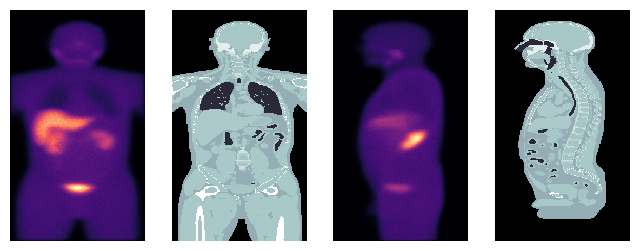

In [18]:
plt.figure(figsize=(8,3))
plt.subplot(141)
plt.pcolormesh(projections[0,0].cpu().T, cmap='magma')
plt.axis('off')
plt.subplot(142)
plt.pcolormesh(attenuation_map[:,64].cpu().T, cmap='bone')
plt.axis('off')
plt.subplot(143)
# Index 90 for 270 degrees (dtheta=3 degrees)
plt.pcolormesh(projections[0,90].cpu().T, cmap='magma')
plt.axis('off')
plt.subplot(144)
plt.pcolormesh(attenuation_map[64].cpu().T, cmap='bone')
plt.axis('off')
plt.show()

The following transform is for PSF modeling in the system matrix. It obtains required detector parameters from one of the header files.

In [19]:
psf_meta = simind.get_psfmeta_from_header(headerfiles[0])
psf_transform = SPECTPSFTransform(psf_meta)

The system matrix $H$ is built by using these transforms:

In [20]:
system_matrix = SPECTSystemMatrix(
    obj2obj_transforms = [att_transform,psf_transform],
    proj2proj_transforms = [],
    object_meta = object_meta,
    proj_meta = proj_meta
    )

## 3. Defining The Likelihood

The likelihood function specifies $L(g|f)$ or the likelihood of measuring the data $g$ given an object estimate $f$. Reconstruction algorithms are used to maximize this likelihood. When $g$ is Poisson (which is always the case for SPECT/PET) the log likelihood takes the form

$$L(g|f) = \sum_i g_i \log (Hf+s)_i - (Hf+s)_i + ...$$

We specify the likelihood 

In [21]:
likelihood = PoissonLogLikelihood(system_matrix, photopeak, additive_term=scatter)

## 4. Reconstruction Algorithms

With the likelihood established, we can now reconstruct our data. This tutorial will focus on ordered-subset preconditioned gradient ascent algorithms, which all have the form

$$\hat{f}^{n,m+1} = \hat{f}^{n,m} + C^{n,m+1}(\hat{f}^{n,m}) \left[\nabla_{f^{n,m}} L(g|f^{n,m}) - \beta \nabla_{f^{n,m}} V \right] $$

* $\hat{f}^{n,m}$ is the object estimate of the nth iteration and the mth subset
* $C^{n,m+1}(\hat{f}^{n,m})$ is the preconditioner, which can depend on the current image estimate $\hat{f}^{n,m}$
* $\nabla_{f^{n,m}} L(g|f^{n,m})$ is the gradient of the likelihood function
* $\nabla_{f^{n,m}} V$ is the gradient of some additional penalization or prior function, and $\beta$ is a scaling factor.

### 4.1 OSEM

The ordered-subset expectation maximum algorithm (OSEM) in SPECT imaging corresponds to

* $C^{n,m+1}(\hat{f}^{n,m}) = \hat{f}^{n,m} / H_T^m 1$
* $\nabla_{f^{n,m}} L(g|f^{n,m}) = H_m^T \left(\frac{g_m}{H_m \hat{f}^{n,m} + s_m}-H^T_m 1\right)$ -> this is because of Poisson statistics
* $V=0$

so the reconstruction algorithm can be written as

$$\hat{f}^{n,m+1} = \left[\frac{1}{H_m^T 1} H_m^T \left(\frac{g_m}{H_m\hat{f}^{n,m}+s_m}\right)\right] \hat{f}^{n,m}$$

To reconstruct with OSEM, we first create the reconstruction algorithm, then specify the number of iterations/subsets required for reconstruction.

In [22]:
recon_algorithm = OSEM(likelihood)
recon_OSEM = recon_algorithm(n_iters = 4, n_subsets = 8)

The returned object has the following shape:

In [23]:
recon_OSEM.shape

torch.Size([128, 128, 384])

Meaning we have a 3D object of shape 128 $\times$ 128 $\times$ 384. We can look at coronal and sagittal slices of the reconstruction:

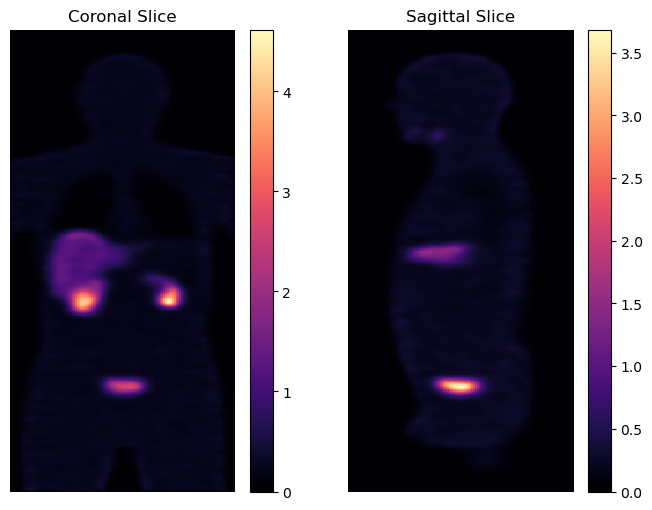

In [24]:
plt.subplots(1,2,figsize=(8,6))
plt.subplot(121)
plt.pcolormesh(recon_OSEM.cpu()[:,70].T, cmap='magma')
plt.colorbar()
plt.axis('off')
plt.title('Coronal Slice')
plt.subplot(122)
plt.pcolormesh(recon_OSEM.cpu()[70].T, cmap='magma')
plt.colorbar()
plt.axis('off')
plt.title('Sagittal Slice')
plt.show()

## 4.2 OSMAPOSL

The ordered subset maximum a posteriori one step late (OSMAPOSL) algorithm is an extension of OSEM that encorporates a prior function $V$

* $C^{n,m+1}(\hat{f}^{n,m}) = \frac{\hat{f}^{n,m}}{H_T^m 1 + \beta \nabla_{f^{n,m}} V}$
* $\nabla_{f^{n,m}} L(g|f^{n,m}) = H_m^T \left(\frac{g_m}{H_m \hat{f}^{n,m} + s_m}-H^T_m 1\right)$ -> this is because of Poisson statistics

Thus the algorithm can be written as

$$\hat{f}^{n,m+1} = \left[\frac{1}{H_m^T 1  + \beta \nabla_{f^{n,m}} V} H_m^T \left(\frac{g_m}{H_m\hat{f}^{n,m}+s_m}\right)\right] \hat{f}^{n,m} $$

The user need to provide the smoothing function $V$. In this case, we'll use a relative difference penalty for each voxel that only includes contributing terms from the 8 nearest neighbours based on the anatomical image.

* `beta` (which is $\beta$ above) is the scaling factor for the prior
* `gamma` is a hyperparameter for the relative difference prior.

In [25]:
weight_top8anatomy = TopNAnatomyNeighbourWeight(attenuation_map, N_neighbours=8)
prior_rdpap = RelativeDifferencePrior(beta=0.3, gamma=2, weight=weight_top8anatomy)
# to use all nearest neighbours (non attenuation map based) use the code below:
# prior_rdp = RelativeDifferencePrior(beta=0.3, gamma=2)

Then we define the algorithm like before and reconstruct

In [26]:
recon_algorithm_osmaposl = OSMAPOSL(
    likelihood = likelihood,
    prior = prior_rdpap)
recon_osmaposl = recon_algorithm_osmaposl(n_iters = 40, n_subsets = 8)

Using the nearest neighbour prior works particularily well for this simple ideal case where the attenuation map is aligned with the phantom, but it doesn't necessarily work as well in clinical practice when the scans are misaligned

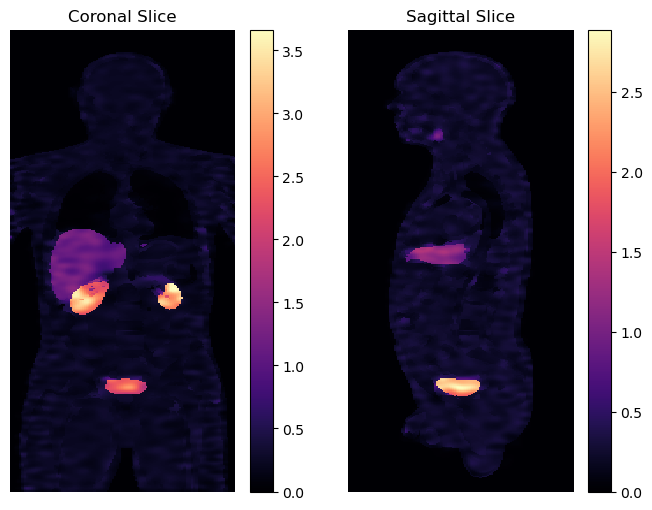

In [27]:
plt.subplots(1,2,figsize=(8,6))
plt.subplot(121)
plt.pcolormesh(recon_osmaposl.cpu()[:,70].T, cmap='magma')
plt.colorbar()
plt.axis('off')
plt.title('Coronal Slice')
plt.subplot(122)
plt.pcolormesh(recon_osmaposl.cpu()[70].T, cmap='magma')
plt.colorbar()
plt.axis('off')
plt.title('Sagittal Slice')
plt.show()

### 4.3 BSREM

The Block Sequential Regularized Expectation Maximum (BSREM) algorithm is another way of incorporating a prior funciton in a reconstruction algorithm. It has the form

* $C^{n,m+1}(\hat{f}^{n,m}) = \alpha_n \frac{\hat{f}^{n,m}}{\omega_m H^T 1}$ where $\alpha_n$ is a user defined "relaxation" sequence and $\omega_n = S_m/M$ is the fraction of subsets considered $S_m$ divided by the total number of subsets $M$
* $\nabla_{f^{n,m}} L(g|f^{n,m}) = H_m^T \left(\frac{g_m}{H_m \hat{f}^{n,m} + s_m}-H^T_m 1\right)$ -> this is because of Poisson statistics

The reconstruction algorithm can thus be written as

$$\hat{f}^{n,m+1} = \hat{f}^{n,m} + \alpha_n \frac{\hat{f}^{n,m}}{\omega_m H^T 1} \left[H_m^T \left(\frac{g_m}{H_m \hat{f}^{n,m} + s_m} -1 \right) - \beta \nabla_{f^{n,m}} V \right] $$

In addition to the prior $V$, we also specify the relaxation sequence $\alpha_n$ when creating the algorithm (if `relaxation_sequence` is not provided, it defaults to 1 for all $n$)

In [28]:
weight_top8anatomy = TopNAnatomyNeighbourWeight(attenuation_map, N_neighbours=8)
prior_rdpap = RelativeDifferencePrior(beta=0.3, gamma=2, weight=weight_top8anatomy)
recon_algorithm_bsrem = BSREM(
    likelihood = likelihood,
    prior = prior_rdpap,
    relaxation_sequence = lambda n: 1/(n/50+1))
recon_bsrem = recon_algorithm_bsrem(40,8)

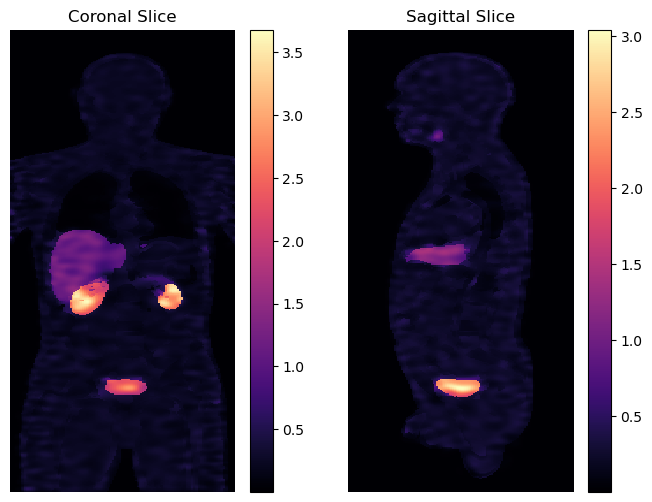

In [29]:
plt.subplots(1,2,figsize=(8,6))
plt.subplot(121)
plt.pcolormesh(recon_bsrem.cpu()[:,70].T, cmap='magma')
plt.colorbar()
plt.axis('off')
plt.title('Coronal Slice')
plt.subplot(122)
plt.pcolormesh(recon_bsrem.cpu()[70].T, cmap='magma')
plt.colorbar()
plt.axis('off')
plt.title('Sagittal Slice')
plt.show()

### 4.4 KEM

The kernel expectation maximum (KEM) algorithm assumes the reconstructed object $\hat{f}^{n,m}$ can be represented by a kernel operator acting on a correspond 3D "image" of coefficients $\hat{\alpha}^{n,m}$ such that $\hat{f}^{n,m} = K \hat{\alpha}^{n,m}$. The coefficient image $\hat{\alpha}^{n,m}$ is obtained via regular OSEM updates with a modified system matrix $\tilde{H}_m = H_m K$, so image updates (in SPECT/PET) have the form:

$$\hat{\alpha}^{n,m+1} = \left[\frac{1}{\tilde{H}_m^T 1} \tilde{H}_m^T \left(\frac{g_m}{\tilde{H}_m\hat{\alpha}^{n,m}+s}\right)\right] \hat{\alpha}^{n,m}$$

and the final image is givenby $\hat{f}^{n,m} = K \hat{\alpha}^{n,m}$.

We start by defining the kernel transform $K$. The matrix $K$ is a square matrix with components

$$K_{ij} = \left(\prod_{v \in S_v} k_v(v_i, v_j; ...) \right) k_x(x_i, x_j; ...)$$

where 

* $v$ corresponds to a "support object" (such as a CT scan, MRI, PET). These are denoted as `support_objects`
* $S_v$ corresponds to the set of all support objects used
* $k_v$ is the support kernel for support image $v$. These are denoted as `support_kernels`.
* $x_i$ is the position of voxel $i$
* $k_x$ is the kernel that weights based on positional differences. This is denoted as `distance_kernel`.
* ... are additional parameters for each kernel. They are denoted as `distance_kernel_params` or `support_kernel_params`/

In the `KEMTransform`, one gives a list of all the support objects via the `support_objects` argument. By default, the support kernel for each support object will be

$$k_v(v_i, v_j; \sigma) = \exp\left( -\frac{(v_i-v_j)^2}{2\sigma^2}\right)$$

In this default kernel, there is *one* additional required argument: $\sigma$. The values of $\sigma$ can be given using the `support_kernels_params` argument. The argument is a list of lists, where each internal list corresponds to all the additional required parameters for each kernel function. In the example below, one support object is used, and the function takes in one additional argument, so specifying $\sigma=0.005$ cm $^{-1}$ requires giving `support_kernels_params=[[0.005]]`. Since there is a single distance kernel, any additional parameters to that kernel are given by a single list to the `distance_kernel_params` argument Alternative kernels can be specified using the `support_kernels` and `distance_kernel` arguments of the function; in this tutorial, we make use of the default ones:

* **Note**: You may have to set `kernel_on_gpu=False` if your computer runs out of GPU memory; this means the kernel gets stored in regular RAM. Only portions of it get put on GPU during run time, but this results in a much longer run time (3x as long)

In [30]:
kem_transform = KEMTransform(
    support_objects=[attenuation_map],
    support_kernels_params=[[0.005]],
    distance_kernel_params=[0.4],
    top_N = 40,
    kernel_on_gpu=True
    )

This transform is used to build the system matrix $\tilde{H} = HK$

In [31]:
system_matrix_kem = KEMSystemMatrix(system_matrix, kem_transform)

/data/anaconda/envs/pytomo_install_test/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


One also has to define a new likelihood function, since the system matrix has now changed

In [32]:
likelihood_kem = PoissonLogLikelihood(system_matrix_kem, photopeak, additive_term=scatter)

We then create the KEM reconstruction algorithm, which iterates over the $\hat{\alpha}^{n,m}$ and automatically computes $\hat{f}^{n,m} = K \hat{\alpha}^{n,m}$ at output:

In [33]:
recon_algorithm_kem = KEM(likelihood_kem)
recon_kem = recon_algorithm_kem(40,8)

And we can plot

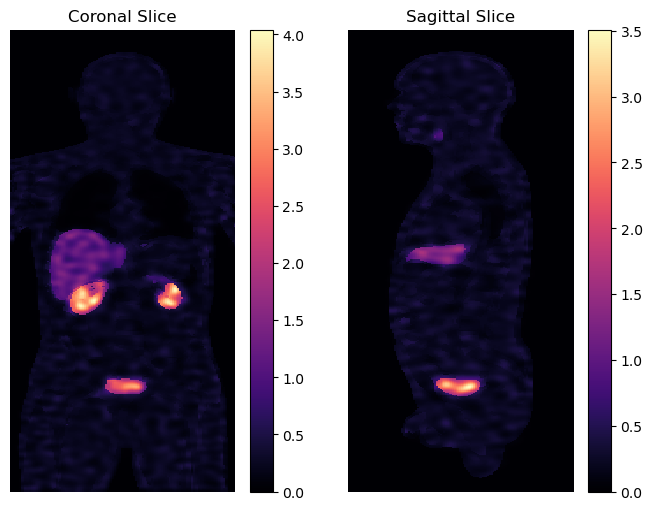

In [34]:
plt.subplots(1,2,figsize=(8,6))
plt.subplot(121)
plt.pcolormesh(recon_kem.cpu()[:,70].T, cmap='magma')
plt.colorbar()
plt.axis('off')
plt.title('Coronal Slice')
plt.subplot(122)
plt.pcolormesh(recon_kem.cpu()[70].T, cmap='magma')
plt.colorbar()
plt.axis('off')
plt.title('Sagittal Slice')
plt.show()